In [44]:
!pip install scikit-plot

In [45]:
from sklearn.base import BaseEstimator
from sklearn.svm import SVR
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion
from IPython import get_ipython
from IPython.display import display, HTML

from sklearn.base import TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR

import os
import random
import numpy as np
import pandas as pd
import pandas_profiling as pp
import cufflinks as cf
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from yellowbrick.features import Rank2D
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

In [46]:
# ***** OBS!: Using too few rows will crash QuantileTransformer! *****
# Define debug mode
#D = True
D = False

# Define visualization mode
Data_Analyze = True
#Data_Analyze = False
View_Plots = True
#View_Plots = False
View_Processed = True
#View_Processed = False

# Define grid search mode
#Grid_Search = False
Grid_Search = True

In [47]:
random.seed(139)

In [50]:
tr_df = pd.read_csv('/content/train.csv')
# Sort values based on 'Feature_7'
tr_df.sort_values(by=['Feature_7'])
ts_df = pd.read_csv('/content/test_2.csv')

# Aggregate intraday returns
intrad_returns = []
returns = ['Ret_MinusTwo', 'Ret_MinusOne']
tr_aggregated_returns = pd.DataFrame(columns=['Ret_Agg', 'Ret_Agg_Std', 'Ret_Std', ])
ts_aggregated_returns = pd.DataFrame(columns=['Ret_Agg', 'Ret_Agg_Std', 'Ret_Std'])

for i in range(2, 121):
    intrad_returns.append(f'Ret_{i}')

tr_aggregated_returns['Ret_Agg'] = tr_df[intrad_returns].sum(axis=1)
tr_aggregated_returns['Ret_Agg_Std'] = tr_df[intrad_returns].std(axis=1)
tr_aggregated_returns['Ret_Std'] = tr_df[returns].std(axis=1)
tr_df = pd.concat([tr_df, tr_aggregated_returns], axis=1)

ts_aggregated_returns['Ret_Agg'] = ts_df[intrad_returns].sum(axis=1)
ts_aggregated_returns['Ret_Agg_Std'] = ts_df[intrad_returns].std(axis=1)
ts_aggregated_returns['Ret_Std'] = ts_df[returns].std(axis=1)
ts_df = pd.concat([ts_df, ts_aggregated_returns], axis=1)

# Prepare train, validation and test data
feat = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6',
        'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12',
        'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18',
        'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24',
        'Feature_25', 'Ret_MinusTwo', 'Ret_MinusOne', 'Ret_Agg', 'Ret_Agg_Std', 'Ret_Std', ]
tar = ['Ret_PlusOne', 'Ret_PlusTwo']
intrad_weights = 'Weight_Intraday'
daily_weights = 'Weight_Daily'
w = [intrad_weights, daily_weights]
feat_tar = feat + tar

tr_X_Y_df = tr_df[feat + tar]
tr_X_df = tr_df[feat]
tr_Y_df = tr_df[tar]
tr_daily_weights_df = tr_df[daily_weights]
ts_X_df = ts_df[feat]

print(f'Dimensions of training feature data: {tr_X_df.shape}')
print(f'Dimensions of training target data: {tr_Y_df.shape}')
print(f'Dimensions of test feature data: {ts_X_df.shape}')

Dimensions of training feature data: (40000, 30)
Dimensions of training target data: (40000, 2)
Dimensions of test feature data: (120000, 30)


In [53]:
def outliers(c):
    stdev3 = c.std() * 3
    avg = c.mean()
    a = 0
    for r in c:
        if (abs(r - avg) > stdev3):
            a = a + 1
    return a

def df_analyze(name, df_tr, df_ts=None, percentage=True):
    ts_set = ()
    values = []
    values_percent = []
    for c in df_tr:
        if df_ts is not None:
            ts_set = set(df_ts[c])
        switcher = {
            'Missing': sum(df_tr[c].isnull()),
            'Unique': len(df_tr[c].unique()),
            'Imbalance': df_tr[c].value_counts().values[0],
            'Outlier': outliers(df_tr[c]),
            'Disjoint': set(df_tr[c]).isdisjoint(ts_set)
        }
        value = switcher.get(name)
        values.append(value)
        values_percent.append(value/len(df_tr[c])*100)
    if percentage:
        df_result = pd.DataFrame(list(zip(values, values_percent)), columns=[name, f'{name} %'])
    else:
        df_result = pd.DataFrame(list(zip(values)), columns=[name])
    return df_result


if Data_Analyze:
    data_miss = df_analyze('Missing', tr_X_Y_df)
    data_unq = df_analyze('Unique', tr_X_Y_df)
    data_bal = df_analyze('Imbalance', tr_X_Y_df)
    data_outlier = df_analyze('Outlier', tr_X_Y_df)
    data_disjoint = df_analyze('Disjoint', tr_X_df, ts_X_df, False)
    data_analyze = pd.concat([pd.DataFrame(tr_X_Y_df.columns), data_miss, data_unq,
                              data_bal, data_outlier, data_disjoint], axis=1)
    print(data_analyze)

               0  Missing  Missing %  ...  Outlier  Outlier %  Disjoint
0      Feature_1    33313    83.2825  ...        0     0.0000     False
1      Feature_2     9146    22.8650  ...       62     0.1550      True
2      Feature_3     1237     3.0925  ...      269     0.6725      True
3      Feature_4     7721    19.3025  ...       80     0.2000      True
4      Feature_5        0     0.0000  ...        0     0.0000     False
5      Feature_6     1933     4.8325  ...     1018     2.5450      True
6      Feature_7        0     0.0000  ...        0     0.0000      True
7      Feature_8      469     1.1725  ...        0     0.0000     False
8      Feature_9     1875     4.6875  ...      237     0.5925     False
9     Feature_10    19471    48.6775  ...      778     1.9450     False
10    Feature_11      987     2.4675  ...      605     1.5125      True
11    Feature_12     1096     2.7400  ...        0     0.0000     False
12    Feature_13      594     1.4850  ...        0     0.0000   

In [ ]:
if Data_Analyze:
    feat_grp = defaultdict(list)
    for i, r in tr_df.iterrows():
        value = r['Ret_PlusOne']
        if value > 0:
            feat_grp[r['Feature_7']].append(1)
        else:
            feat_grp[r['Feature_7']].append(-1)

    frequency = 0
    for k, v in feat_grp.items():
        freq0 = v.count(1)/len(v)
        freq1 = len(v) - freq0
        freq2 = max(freq0, freq1)
        frequency += frequency/len(v)
    frequency = frequency / len(feat_grp)

    print(f'Frequence of return signs: {frequency}')

Frequence of return signs: 0.9886483932059086


In [54]:
def plot(tr_df: pd.DataFrame, ts_df: pd.DataFrame, features: list,
         transformer: Pipeline = None, frac: float = 0.1, label: str = ''):

    tr_data = tr_df.sample(frac=frac, random_state=0)
    ts_data = ts_df.sample(frac=frac, random_state=0)

    if transformer is not None:
        tr_data = transformer.fit_transform(tr_data[features])
        tr_data_df = pd.DataFrame(tr_data, columns=features)
        ts_data = transformer.transform(ts_data[features])
        ts_data_df = pd.DataFrame(ts_data, columns=features)
    else:
        imp = SimpleImputer(strategy='constant')
        tr_data_df = pd.DataFrame(imp.fit_transform(tr_df[features]), columns=features)
        ts_data_df = pd.DataFrame(imp.fit_transform(ts_df[features]), columns=features)

    print(label)
    figure, ax = plt.subplots(round(len(features) / 3), 3, figsize=(15, 15))
    for i, ax in enumerate(figure.axes):
        if i < len(features):
            sns.distplot(tr_data_df[features[i]], color='blue', ax=ax)
            sns.distplot(ts_data_df[features[i]], color='red', ax=ax)


if View_Plots:
    plot_data = tr_X_Y_df.sample(frac=0.1, random_state=0)
    imp = SimpleImputer(strategy='constant')
    plot_data_no_nan = pd.DataFrame(imp.fit_transform(data_plot), columns=feat_tar)
    numerical_features = ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_6',
                          'Feature_11', 'Feature_14', 'Feature_15',
                          'Feature_17', 'Feature_18', 'Feature_19',
                          'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25',
                          'Ret_MinusTwo', 'Ret_MinusOne', 'Ret_Agg']
    categorical_features = ['Feature_5', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
                            'Feature_12', 'Feature_13', 'Feature_16', 'Feature_20']


Correlation heatmap:


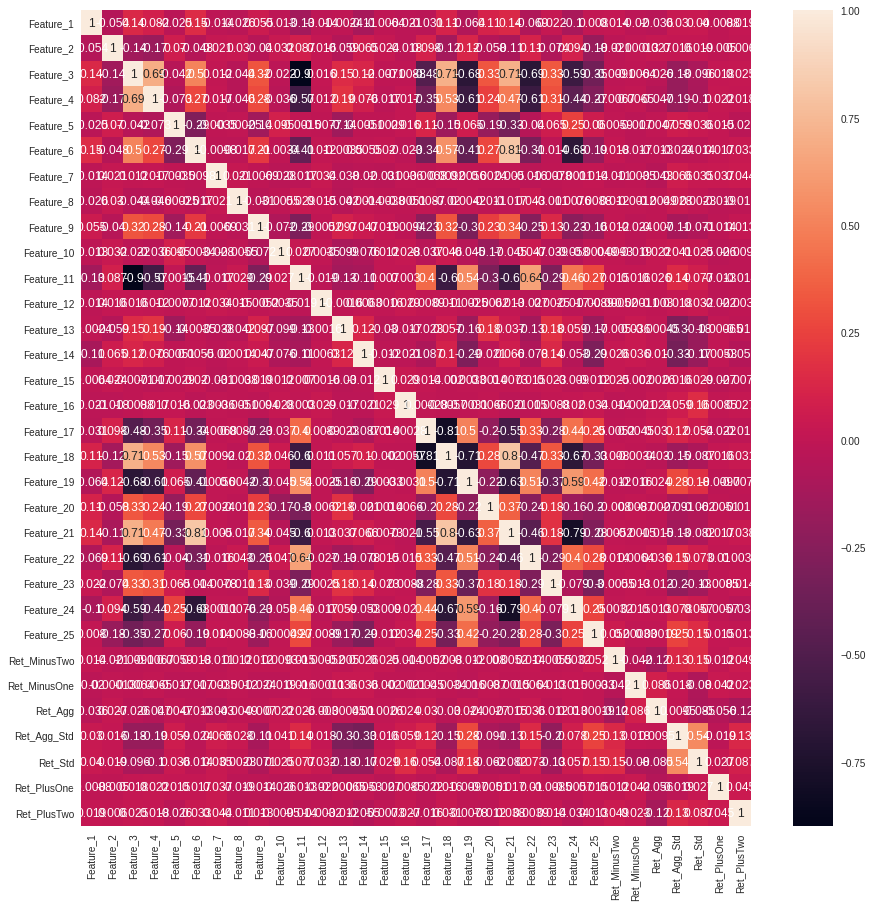

In [55]:
if View_Plots:
    # Correlation heatmap for all features and targets
    print("Correlation heatmap:")
    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(plot_data_no_nan.corr(), annot=True, ax=ax)

Correlation heatmap for numerical features:


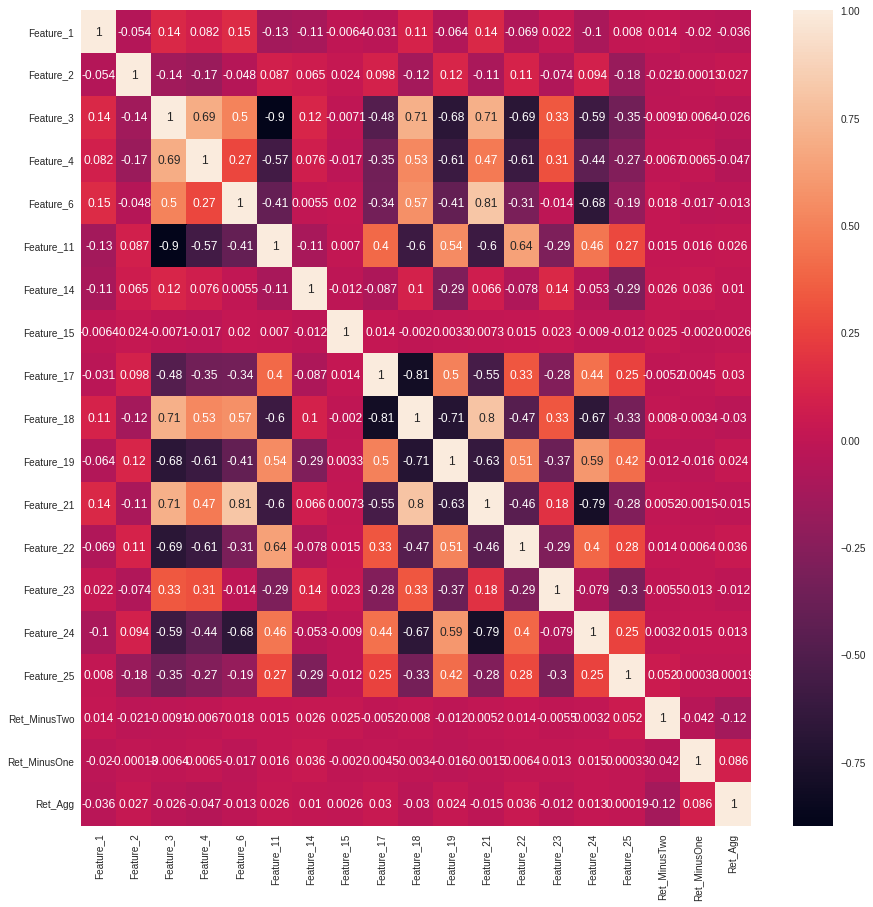

In [56]:
if View_Plots:
    # Correlation heatmap for numerical features
    print("Correlation heatmap for numerical features:")
    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(plot_data_no_nan[numerical_features].corr(), annot=True, ax=ax)

Correlation heatmap for categorical features:


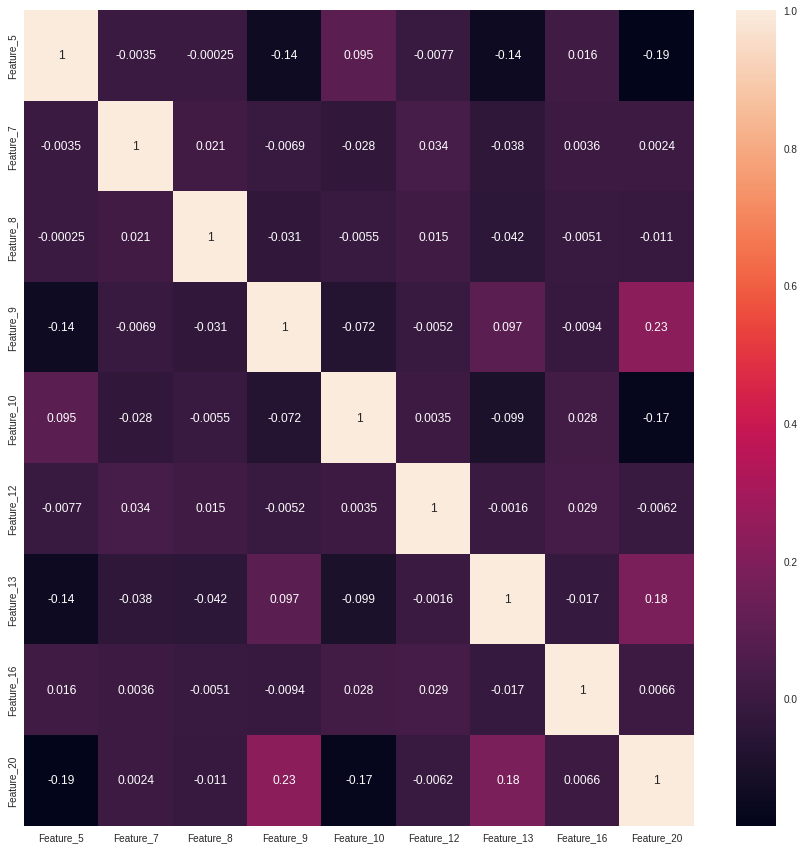

In [57]:
if View_Plots:
    # Correlation heatmap for categorical features
    print("Correlation heatmap for categorical features:")
    f, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(data_plot_no_nan[categorical_features].corr(), annot=True, ax=ax)

Raw distributiions: Features


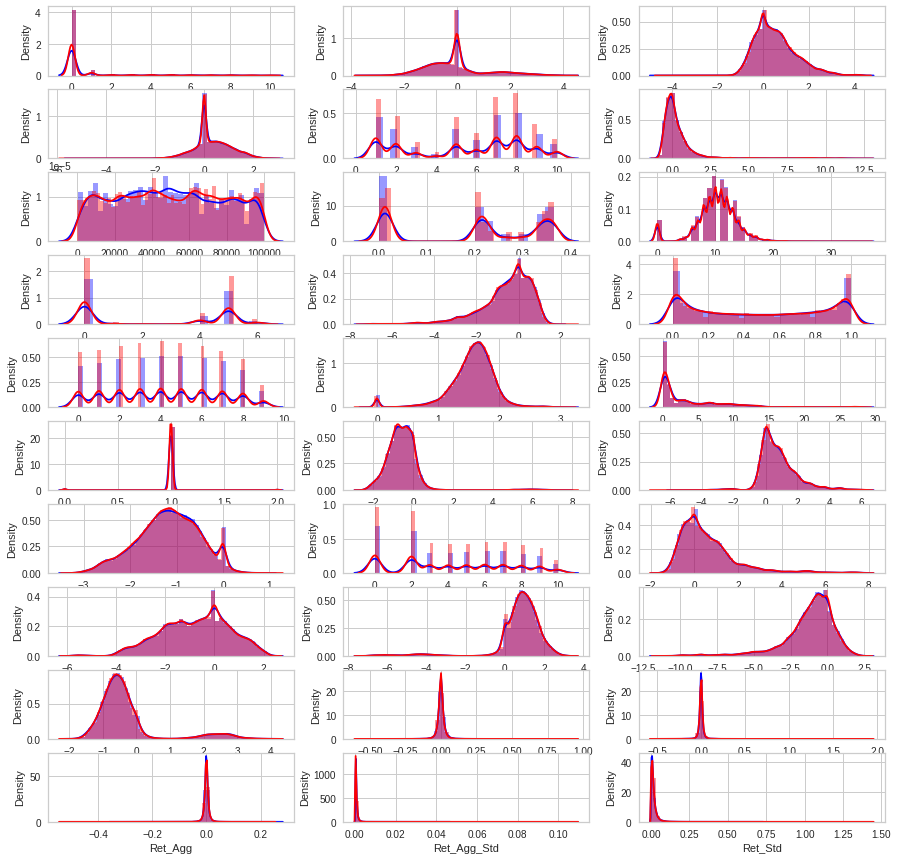

In [58]:
if View_Plots:
    # Distributions
    plot(tr_X_df, ts_X_df, features=feat, label='Raw distributiions: Features')

Regression plots:


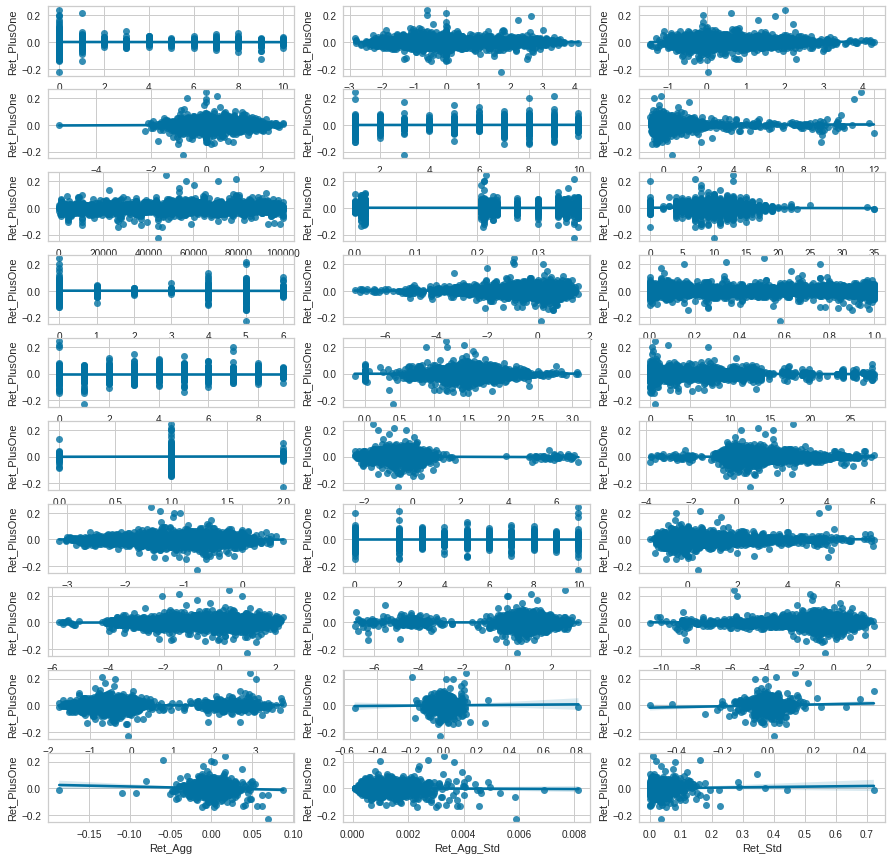

In [60]:
if View_Plots:
    # Regression plots
    print("Regression plots:")
    figure, ax = plt.subplots(round(len(feat) / 3), 3, figsize=(15, 15))
    for i, ax in enumerate(figure.axes):
        if i < len(feat):
            sns.regplot(x=feat[i], y=tar[0], data=plot_data_no_nan, ax=ax)

In [61]:
# Define final features
final_numerical_feat = ['Feature_2', 'Feature_3', 'Feature_4', 'Feature_6',
                        'Feature_11', 'Feature_14',
                        'Feature_17', 'Feature_18', 'Feature_19',
                        'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25',
                        'Ret_MinusTwo', 'Ret_MinusOne', 'Ret_Agg', 'Ret_Agg_Std',
                        'Ret_Std']

categorical_feat_ord_final = ['Feature_13']

categorical_feat_nom_final = ['Feature_1', 'Feature_5', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
                              'Feature_12', 'Feature_15', 'Feature_16', 'Feature_20']

final_categorical_feat = categorical_feat_ord_final + categorical_feat_nom_final
final_feat = final_numerical_feat + final_categorical_feat

tr_X_df = tr_df[final_feat]
ts_X_df = ts_df[final_feat]

In [64]:
class CutOff(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        X[X > 3] = 3
        X[X < -3] = -3
        return X

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('scale', RobustScaler(quantile_range=[5, 95])),
    ('quantile', QuantileTransformer(n_quantiles=300, output_distribution='normal', random_state=0)),
    ('cutoff', CutOff()),  
    ('norm', Normalizer(norm='l2'))
])

# Preprocessing for nominal categorical data
categorical_transformer_nom = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('pca', PCA(whiten=True, random_state=0)),
    ('bins', KBinsDiscretizer(n_bins=100, encode='onehot', strategy='quantile')),
    ('norm', Normalizer(norm='l2')),
])

# Preprocessing for ordinal categorical data
categorical_transformer_ord = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('bins', KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='quantile')),
    ('norm', Normalizer(norm='l2')),
])

# Combined preprocessing for numerical and categorical data
X_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, final_numerical_feat),        
        ('cat_nom', categorical_transformer_nom, categorical_feat_nom_final),
        ('cat_ord', categorical_transformer_ord, categorical_feat_ord_final)        
    ])

# Testing preprocessor
X_preprocessor_shape = X_preprocessor.fit_transform(tr_X_df).shape
print(f'X_preprocessor output shape: {X_preprocessor_shape}')

# Target transformer
Y_preprocessor = Pipeline(steps=[
    ('quantile', QuantileTransformer(n_quantiles=300, output_distribution='normal', random_state=0))
])

X_preprocessor output shape: (40000, 1020)


In [70]:
if (View_Processed):
    # Transform numerical features and targets
    plot_data = tr_X_Y_df.sample(frac=0.1, random_state=0)
    imp = SimpleImputer(strategy='constant')
    plot_data_no_nan = pd.DataFrame(
        imp.fit_transform(plot_data), columns=feat_tar)

    transformed_numerical = numerical_transformer.fit_transform(
        plot_data_no_nan[final_numerical_feat])
    vis_tr_X_numerical_df = pd.DataFrame(
        transformed_numerical, columns=final_numerical_feat)
    vis_tr_Y_df = pd.DataFrame(
        Y_preprocessor.fit_transform(tr_Y_df), columns=tar)
    vis_tr_X_Y_numerical_df = pd.concat(
        [vis_tr_X_numerical_df, vis_tr_Y_df], axis=1)

    transformed_categorical = categorical_transformer_nom.fit_transform(
        numerical_transformer.fit_transform(plot_data_no_nan[final_categorical_feat]))
    d = 20
    pca_categorical_feat = []
    for i in range(0, d):
        pca_categorical_feat.append(f'{i}')
    pca_categorical_transformed = TruncatedSVD(
        n_components=d).fit_transform(transformed_categorical)
    vis_tr_X_categorical_df = pd.DataFrame(
        pca_categorical_transformed, columns=pca_categorical_feat)
    vis_tr_X_Y_categorical_df = pd.concat(
        [vis_tr_X_categorical_df, vis_tr_Y_df], axis=1)

After preproccssing numerical features: Distributions:


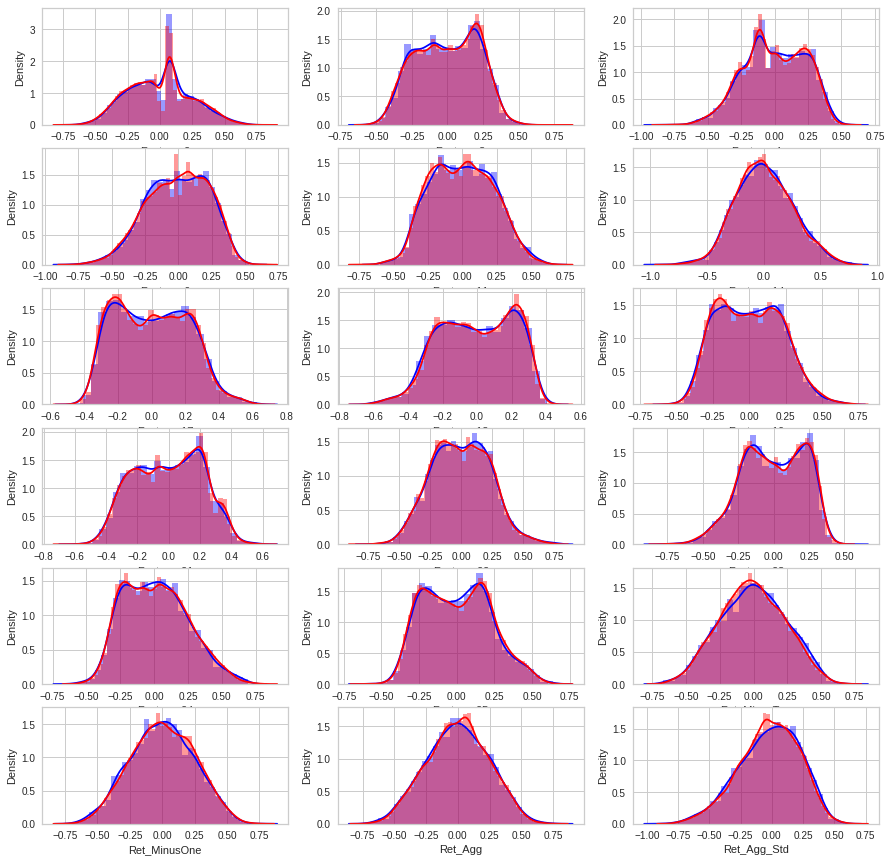

In [72]:
if (View_Plots):
    # Distributions of numerical features after preprocssesing
    plot(tr_X_df, ts_X_df, features=final_numerical_feat, transformer=numerical_transformer,
         label='After preproccssing numerical features: Distributions:')

After preproccssing numerical features: Regression plots:


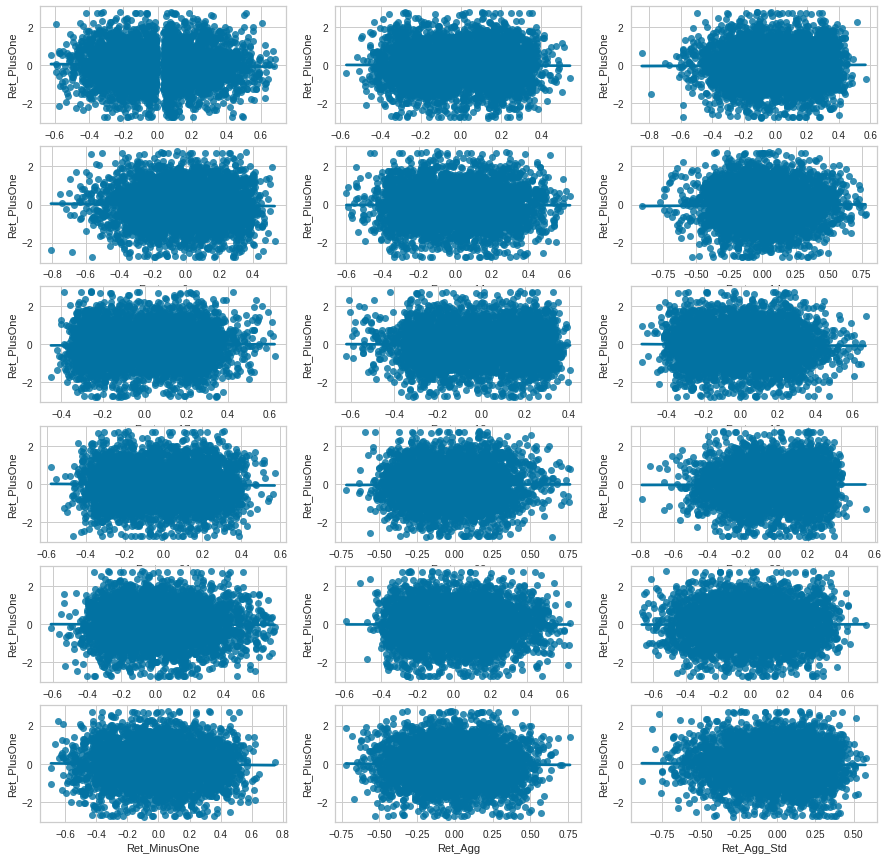

In [73]:
if (View_Processed):
    # Regression plots of numerical features after preprocssesing
    print("After preproccssing numerical features: Regression plots:")
    fig, ax = plt.subplots(
        round(len(final_numerical_feat) / 3), 3, figsize=(15, 15))
    for i, ax in enumerate(fig.axes):
        if i < len(final_numerical_feat):
            sns.regplot(
                x=final_numerical_feat[i], y=tar[0], data=vis_tr_X_Y_numerical_df, ax=ax)

After preproccssing categorical features: Distributions:


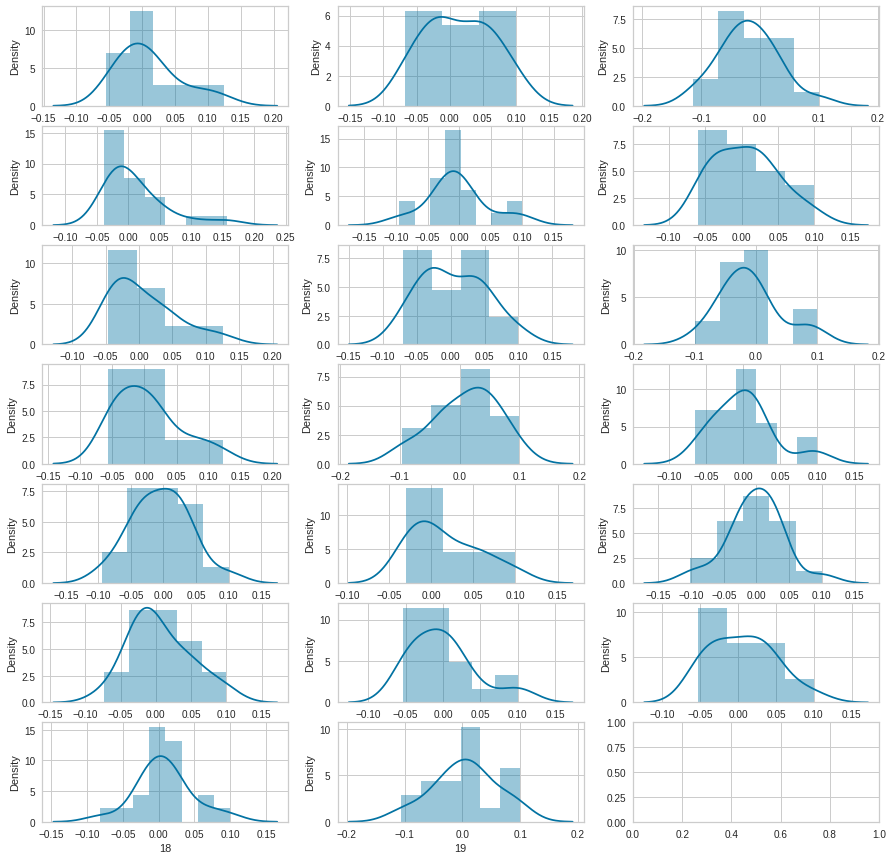

In [76]:
if (View_Processed):
    # Distributions of categorical features after preprocssesing
    print("After preproccssing categorical features: Distributions:")
    fig, ax = plt.subplots(round(d / 3), 3, figsize=(15, 15))
    for i, ax in enumerate(fig.axes):
        if i < dim:            
            sns.distplot(vis_tr_X_categorical_df.iloc[i], ax=ax)

After preproccssing categorical features: Regression plots:


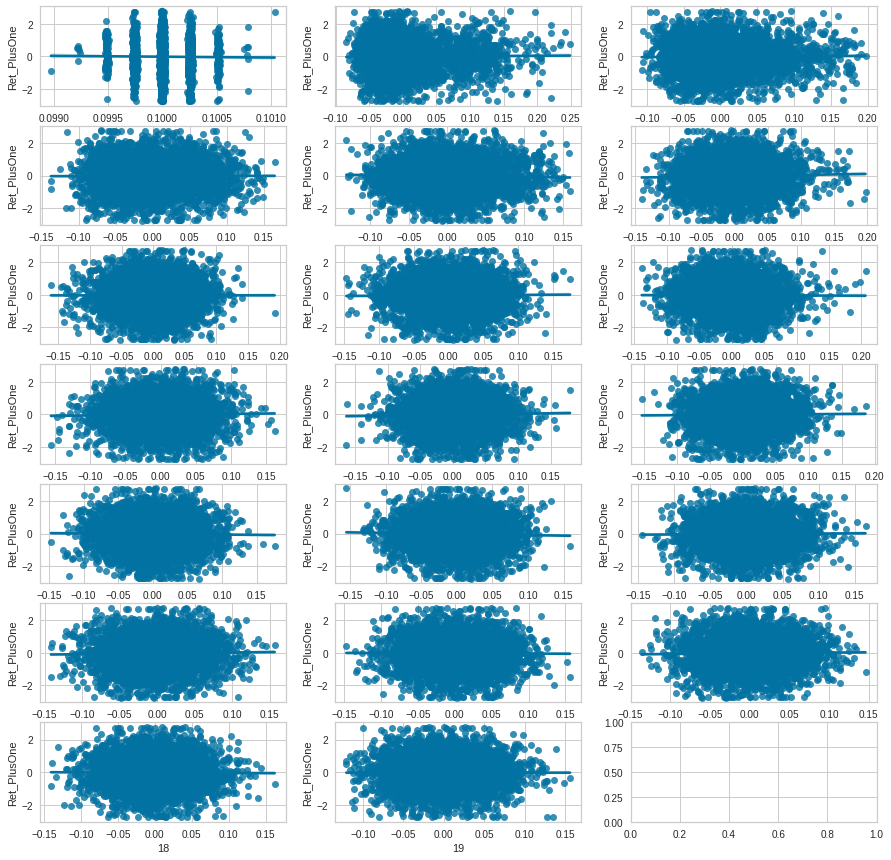

In [77]:
if (View_Processed):
    # Regression plots categorical features after preprocssesing
    print("After preproccssing categorical features: Regression plots:")
    fig, ax = plt.subplots(round(d / 3), 3, figsize=(15, 15))
    for i, ax in enumerate(fig.axes):
        if i < dim:            
            sns.regplot(x=pca_categorical_feat[i], y=tar[0], data=vis_tr_X_Y_categorical_df, ax=ax)

After preproccssing targets: Distributions:


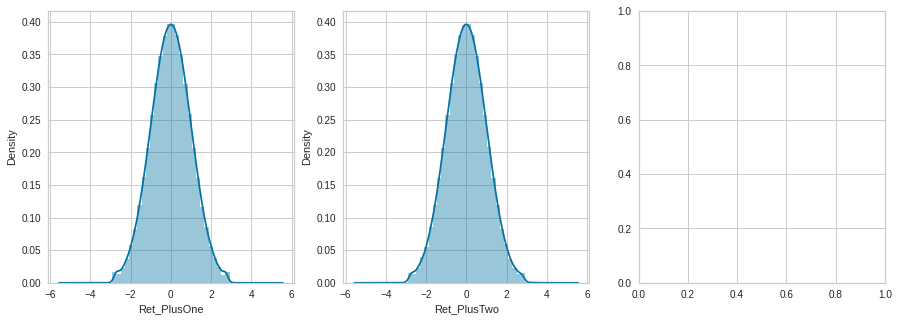

In [78]:
if (View_Processed):
    # Distributions of targets after preprocssesing
    print("After preproccssing targets: Distributions:")
    fig, ax = plt.subplots(round(len(tar) / 3), 3, figsize=(15, 5))
    for i, ax in enumerate(fig.axes):
        if i < len(tar):
            sns.distplot(vis_tr_Y_df[tar[i]], ax=ax)

In [94]:
# Define initial model
m = LinearSVR(epsilon=0.0, C=0.0005, loss='squared_epsilon_insensitive', random_state=0)  # 1727.860

# Define model pipeline for multi output regression
mor = MultiOutputRegressor(m)
m_pipe = Pipeline(steps=[('preprocessor', X_preprocessor), ('multioutreg', mor)])
e = TransformedTargetRegressor(regressor=m_pipe, transformer=Y_preprocessor)

def Weighted_Avg(a, ax, wt):    
    a = np.asanyarray(a)
    weight = np.asanyarray(wt)
    weight = np.broadcast_to(weight, (a.ndim-1)*(1,) + weight.shape)
    weight = weight.swapaxes(-1, ax)
    n = len(a)
    average = np.multiply(a, weight).sum(ax)/n

    return average

def WMAE(y_true, y_pred, sample_weight):    
    op_err = Weighted_Avg(np.abs(y_pred - y_true), wt=sample_weight, ax=0)
    avg = np.average(op_err)

    return avg

if Grid_Search:
    # Define grid parameters to search
    grid_parameters = {
        'regressor__multioutreg__estimator__C': [0.0005, 0.001, 0.0015, 0.002]
    }

    grp = tr_X_df['Feature_7'].values
    cv = list(GroupKFold(n_splits=5).split(tr_X_df, tr_Y_df, grp))

    # Define scoring metric for grid search
    s = 'neg_mean_absolute_error'

    # Define grid search specified scoring and cross-validation generator
    print('Running grid searc CV...')
    gd_sr = GridSearchCV(estimator=e,
                         param_grid=grid_params,
                         scoring=scoring,
                         cv=cv,
                         # n_jobs=8,
                         refit=True)

    # Apply grid search and get parameters for best result
    gd_sr.fit(tr_X_df, tr_Y_df)
    best_parameters = gd_sr.best_params_
    best_estimator = gd_sr.best_estimator_
    score = -gd_sr.best_score_

    print(f'Best parameters = {gd_sr.best_params_}')
    print(f'Best MAE = {score}')

else:
    e.fit(train_X_df, train_Y_df)
    best_estimator = e

print('Done building model')

Running grid searc CV...
Best parameters = {'regressor__multioutreg__estimator__C': 0.0005}
Best MAE = 0.0155313653387252
Done building model


In [95]:
# Predict on train and validation data
tr_Y_pred = best_estimator.predict(tr_X_df)

# Evaluate predictions on train and validation data and compare with baseline mean prediction
Y_mean = [0, 0]
Y_mean[0] = tr_df[tar[0]].mean()
Y_mean[1] = tr_df[tar[1]].mean()

tr_mae = WMAE(tr_Y_df, tr_Y_pred, sample_weight=tr_daily_weights_df)
Y_mean_np = np.concatenate((np.full((tr_Y_df.shape[0], 1), Y_mean[0]), np.full((tr_Y_df.shape[0], 1), Y_mean[1])), axis=1)
mae_mean = WMAE(tr_Y_df, Y_mean_np, sample_weight=tr_daily_weights_df)

# Print scores
print(f'WMAE of fitted model: {tr_mae}')
print(f'WMAE of baseline model: {mae_mean}')

# Predict on test data
Y_test_pred = best_estimator.predict(ts_X_df)

WMAE of fitted model: 27774.431274400948
WMAE of baseline model: 27837.43692154118


In [98]:
Save = True
if Save:
    # Create submission data
    ids = []
    preds = []
    for i, j in ts_df.iterrows():
        for k in range(1, 61):
            ids.append(f'{i+1}_{k}')
            # We predict i_1 - i_60 as 0
            preds.append(0)
        ids.append(f'{i+1}_61')
        preds.append(Y_test_pred[i][0])  # D+1
        ids.append(f'{i+1}_62')
        preds.append(Y_test_pred[i][1])  # D+2

    submission_df = pd.DataFrame(
        list(zip(ids, preds)), columns=['Id', 'Predicted'])
    print(submission_df[(submission_df.Predicted != 0)].head(5))

    # Save submission to csv file
    submission_df.to_csv('result.csv', index=False)

       Id  Predicted
60   1_61  -0.000405
61   1_62   0.000273
122  2_61  -0.000335
123  2_62  -0.000888
184  3_61  -0.000237
